In [1]:
import platform

print(platform.machine())

arm64


In [2]:
import io
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pathlib

import time
from selenium import webdriver
from PIL import Image
from matplotlib import pyplot as plt
import copy

In [3]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
device = torch.device("cpu")

class ImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        labels = np.asarray([dataset[i][1] for i in range(len(dataset))])
        data = np.asarray([dataset[i][0] for i in range(len(dataset))])
        print(data.shape)
        print(labels.shape)
        
        self.img_labels = torch.from_numpy(labels)
        self.img_labels = self.img_labels.to(device)
        
        data = np.moveaxis(data, 3, 1)
        self.img_data = torch.from_numpy(data)
        self.img_data = self.img_data.to(device)
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        #return len(self.img_labels)
        return len(self.img_labels)*50

    def __getitem__(self, idx):
        idx = idx % len(self.img_labels)
        image = self.img_data[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [4]:
import torch.nn as nn

X_train = list()
y_train = list()

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        X_train.append(pix)
        y_train.append(1)
        
length = len(X_train)

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        
        X_train.append(pix)
        y_train.append(0)
        if len(X_train) >= length*2:
            break #prevent one class from being overrepresented

(415, 112, 112, 3)
(415,)
(61, 112, 112, 3)
(61,)
(118, 112, 112, 3)
(118,)


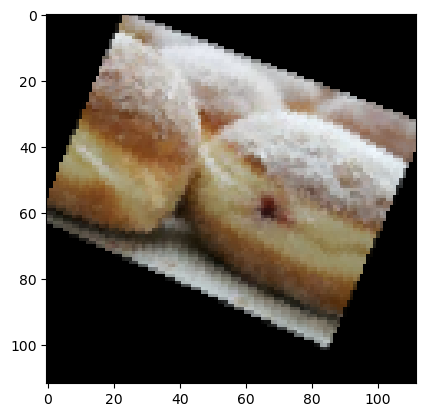

In [5]:
complete_dataset = np.asarray([[X_train[i], y_train[i]] for i in range(len(X_train))], dtype=object)

total_count = len(X_train)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    complete_dataset, (train_count, valid_count, test_count)
)

trainset = ImageDataset(train_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

testset = ImageDataset(test_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

validset = ImageDataset(valid_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))


data, lbl = trainset.__getitem__(400)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)

plt.imshow(data) 
plt.show()


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5, padding=2) 
        self.pool1 = nn.MaxPool2d(2, 2) # 56
        self.conv2 = nn.Conv2d(9, 27, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # 28
        self.conv3 = nn.Conv2d(27, 81, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # 14
        self.fc1 = nn.Linear(81 * 14 * 14, 1024)
        self.dropout1 = nn.Dropout1d(p = 0.5)
        self.fc2 = nn.Linear(1024, 128)
        
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.dropout1(self.fc2(x)))
        x = self.fc3(x)
        return x
    
net = ConvNet()
net.to(device=device);

In [38]:
from tqdm import tqdm
import torch.optim as optim

def train_model(model, optimizer, criterion=nn.CrossEntropyLoss(), epoch_count=10, batch_size=50):
    torch.manual_seed(42)
    best_acc = 0.0
    
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    test_accuracys = []
    running_loss = []

    for epoch in range(epoch_count):  # loop over the dataset multiple times
        model.train(True)
        train_progress  = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=0.3)
        for i, data in enumerate(train_progress, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            # print statistics
            running_loss.append(loss.item())
            train_progress.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.3}")
        
        model.train(False)
        print(f"------ Epoch {epoch+1} ------")
    
        test_loss = 0
        test_accuracy = 0
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
        test_loss = test_loss / len(test_dataloader)
        test_accuracy = test_accuracy / len(test_dataloader)
        
        test_accuracys.append(test_accuracy)
        test_losses.append(test_loss)
        train_losses.append(sum(running_loss)/(len(running_loss)))
        
        if  test_accuracy > best_acc:
            best_acc = test_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"avg. Train loss: {sum(running_loss)/(len(train_dataloader))}")
        print(f"Test loss: {test_loss} | Test accuracy: {test_accuracy}")
        running_loss = []

    print('Finished Training')
    plt.plot(train_losses, label='train loss')
    plt.plot(test_accuracys, label='test accuracy')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    
    model.load_state_dict(best_model_wts)
    
    return model

train_model(net, optim.Adam(net.parameters(), lr=0.001), epoch_count=5)

Epoch 1:   0%|          | 0/415 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x63504 and 15876x1024)

In [ ]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from torchvision.transforms import RandomResizedCrop

"""
trainset = ImageDataset(y_train, X_train, transform=transforms.Compose([
    #RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.5,2))
]))
ml_dataloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)

impr_trainset_data = []
impr_trainset_labels = []
for batch in ml_dataloader:
    data, lbl = batch
    lbl = np.asarray(lbl)[0]
    data = np.asarray(data)
    data = np.moveaxis(data, 0, 2)
    impr_trainset_data.append(data)
    impr_trainset_labels.append(lbl)

impr_trainset_labels = np.asarray(impr_trainset_labels)    
impr_trainset_data = np.asarray(impr_trainset_data)
impr_trainset_data = impr_trainset_data.reshape(-1, 3 * 112 * 112)
""";
impr_trainset_data = X_train.reshape(-1, 3 * 112 * 112)
impr_trainset_labels = y_train

model = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', verbose=1)
model.fit(impr_trainset_data, impr_trainset_labels)

In [ ]:
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/ccd1103058108dca8975f3aa0e15024118d43058.bmp"
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/5d218a52d5657d1b40909b8805944b3f83b29c8d.bmp"
test_pic = Image.open(test_path)
test_data = np.asarray(test_pic)
test_data = (test_data / 255.0)
test_data = test_data.astype(np.float32)
test_data = test_data.reshape(-1, 3 , 112, 112)
test_data = torch.from_numpy(test_data)
test_data = test_data.reshape(-1, 3 * 112 * 112)

pred = model.predict(test_data)
pred

print(f'Actual value from test data is 0 and corresponding image is as below')
plt.matshow(test_data.reshape((112,112,3))) 
plt.show()
print(f'Predicted value from test data is {pred[0]} and corresponding image is as below')



In [17]:
def test_model(model, valid_dataloader, criterion=nn.CrossEntropyLoss()):
    val_loss = 0
    val_accuracy = 0

    #valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)

    for i, data in enumerate(valid_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
    val_loss = val_loss / len(valid_dataloader)
    val_accuracy = val_accuracy / len(valid_dataloader)

    print("accuracy: {}".format(val_accuracy))
    print("loss: {}".format(val_loss))

#test_model(net)

## Now try to solve this task / problem with transfer learning

In [39]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


(415, 224, 224, 3)
(415,)
(61, 224, 224, 3)
(61,)
(118, 224, 224, 3)
(118,)


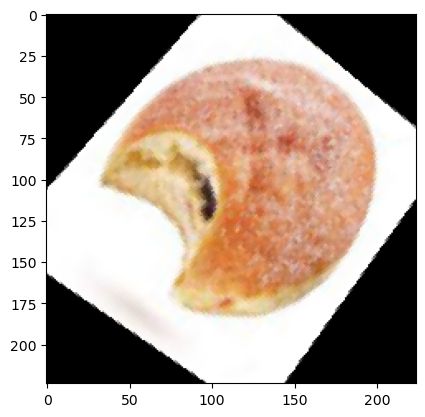

In [40]:
complete_dataset = np.asarray([[X_train[i].repeat(2,axis=0).repeat(2, axis=1), y_train[i]] for i in range(len(X_train))], dtype=object)

total_count = len(X_train)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    complete_dataset, (train_count, valid_count, test_count)
)

trainset = ImageDataset(train_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

testset = ImageDataset(test_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

validset = ImageDataset(valid_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))


data, lbl = trainset.__getitem__(400)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)

plt.imshow(data) 
plt.show()


In [53]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


class TransferResNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet_model = models.resnet18(weights='IMAGENET1K_V1')
        set_parameter_requires_grad(resnet_model, True)

        self.resnet_model = resnet_model
        self.fc = nn.Linear(1000, 256)
        self.dropout = nn.Dropout(p=float(0.5))
        self.fc2 = nn.Linear(256,2)

    def forward(self, x):
        x = self.resnet_model.forward(x)
        x = self.fc(F.relu(x))
        x = self.fc2(F.relu(self.dropout(x)))
        
        return x
        
    
model_ft = TransferResNet()
model_ft.to(device=device);

In [27]:

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        weights = 'NONE'
        if use_pretrained:
            weights = 'IMAGENET1K_V1'
        
        model_ft = models.resnet18(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
#model_ft, input_size = initialize_model("resnet", 2, True, use_pretrained=True)

In [54]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.01)

Params to learn:
	 fc.weight
	 fc.bias
	 fc2.weight
	 fc2.bias


In [55]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = train_model(model_ft, optimizer_ft, criterion, epoch_count=1)

Epoch 1:   0%|          | 0/415 [00:01<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x1000 and 50000x256)

In [24]:
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)
test_model(model_ft, valid_dataloader)

accuracy: 0.4830508474576271
loss: 0.7375495995707431
